# Create a dataset of small boxes of the original stamp

The aim of this notebook is to slice the stamp into small regions of 2,500x2,500 m instead of 25kmx25km.

It means that the original stamp will be sliced into 100 smaller stamps

the steps are

    1 - Create a template box shapely Poligon of 100 boxes
    2 - From the CSV for of each stamp create a gpd series with the shapely Point coordinates
    3 - From 1 and 2 create a stamp map dictionary { 'StampID_Box#': (boxnumber, "commodity", number of deposits)
    4 - Split the raster in small 50x50 files from a original 500x500
    5 - Create a dataset tuple of lists ( list, list, list) being (['StampID_Box#'], [Tile Data], [Labe11], [Labe12]) 
    

In [39]:
# import packages


import numpy as np
import os
import rasterio
import geopandas as gpd
import pandas as pd
from collections import defaultdict
from pathlib import Path
from shapely.geometry import Point
from shapely.geometry import Polygon
from pathlib import Path
import rasterio
%matplotlib inline
import matplotlib.pyplot as plt
from rasterio.windows import Window
from explore_australia.reprojection import reproject
from shapely.geometry import Point

from explore_australia.utilities import omerc_projection
from explore_australia.geometry import make_stamp

from rasterio.mask import mask
from numpy import nan, nanquantile

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import h5py
from datetime import datetime
import json


# 1 - BOX template for stamp

In [2]:
# create a range from -12500 to 12500 which is the x coordinates of the stamp in meters 
start = -12500
xs = [start]

for i in range(10):
    start+= 2500
    xs.append(start)
    
# create a range from -12500 to 12500 which is the y coordinates of the stamp in meters 
start = 12500
ys = [start]

for i in range(10):
    start -= 2500
    ys.append(start)
    
# create a list of tuples of the coors of stamp boxes from bottom to top from left to right
coords = list()
for i in xs:
    for j in ys:
        coords.append((i,j))
        

# create the 100 shape files
nobox = [10,21,32,43,54,65,76,87,98]
boxes = []
for i in range(109):
    if i in nobox:
        continue
    else:
        box = Polygon([coords[i+1], coords[i+12], coords[i+11], coords[i]])
        boxes.append(box)

    

In [3]:
len(boxes)

100

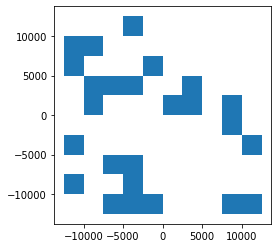

In [4]:
# pick 30 random boxes

random_30 = []
for i in range(30):
    random_30.append(random.choice(boxes))
    
boxes30 = gpd.GeoDataFrame(geometry=random_30)
boxes30.plot();    

In [24]:
minx, miny, maxx, maxy = boxes[0].bounds
x, y = minx + 1250 , miny + 1250

In [52]:
boxes_points = dict()
points = list()
for i, box in enumerate(boxes):
    minx, miny, maxx, maxy = box.bounds
    x, y = minx + 1250 , miny + 1250
    boxes_points[i+1] = (x,y)
    points.append(Point(x,y))
    

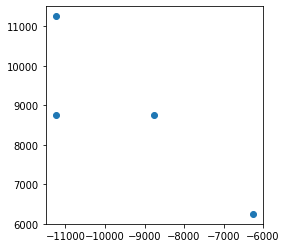

In [55]:
points_gdf = gpd.GeoDataFrame(geometry=[points[0],points[1],points[11],points[22]])
points_gdf.plot(); 

In [38]:

#json.dumps(boxes_points)

with open('boxes_point.json','w') as f:
    json.dump(boxes_points, f)
    



In [43]:
with open('boxes_point.json', 'r') as f:
    loaded_from_file = json.load(f)

In [50]:
type(loaded_from_file['1'])

list

# 2 - Create a Geoseries of the CSV file

In [45]:
# set path of the train dataset
trainpath = '/Users/pedrojunqueira/Desktop/train'

In [46]:
# create a list with the id of the stamps
trainids = os.listdir(trainpath)
len(trainids)

1863

In [47]:
commodity = 'commodities.csv'

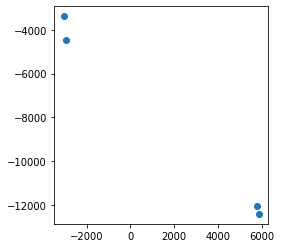

In [48]:
#deps = pd.read_csv(os.path.join(trainpath,trainids[0],commodity))
deps = pd.read_csv(os.path.join(trainpath,"47763108",commodity))
geometry = deps.apply(lambda row: Point(row['x'],row['y']), axis=1)
deps = gpd.GeoDataFrame(deps, geometry=geometry)
deps.plot();


In [49]:
deps

,stamp_id,x,y,commodity,geometry
0,47763108,-2943.373687,-4448.565017,Cu,POINT (-2943.374 -4448.565)
1,47763108,-3038.769050,-3378.388389,Zn;Pb,POINT (-3038.769 -3378.388)
2,47763108,5869.865673,-12416.639513,Mn,POINT (5869.866 -12416.640)
3,47763108,5772.979969,-12067.019114,Mn,POINT (5772.980 -12067.019)


in box (-5000.0, -5000.0, -2500.0, -2500.0) there are 2 deposits
in box (5000.0, -12500.0, 7500.0, -10000.0) there are 2 deposits


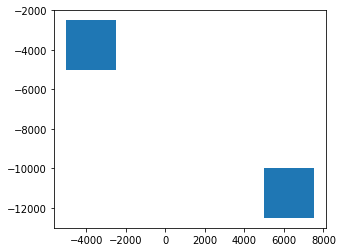

In [50]:
boxes_with_deposit = []
box_number = []
for i, box in enumerate(boxes):
    if deps['geometry'].within(box).sum():
        print(f'in box {box.bounds} there are {deps["geometry"].within(box).sum()} deposits')
        boxes_with_deposit.append(box)
        box_number.append(i+1)
        
boxesframe = gpd.GeoDataFrame(geometry=boxes_with_deposit)
boxesframe.plot();        

In [51]:
box_number

[37, 80]

# 3 - create a stamp map dictionary

In [52]:
start = datetime.now()


# import stamp geodataframe path
stamps_data = '../data/stamp_locations.geo.json'
# create geodataframe objects
stamps = gpd.read_file(stamps_data)

commodity_path = 'commodities.csv'

stamp_map = dict()
for n, train_i in enumerate(trainids):
    deps = pd.read_csv(os.path.join(trainpath,train_i,commodity_path))
    if deps.shape[0] == 0:
        stamp_id = train_i
        for i, box in enumerate(boxes):
            stamp_map[f'{stamp_id}_{i+1}'] = (i, 'none', 'none',0)
    else:
        geometry = deps.apply(lambda row: Point(row['x'],row['y']), axis=1)
        deps = gpd.GeoDataFrame(deps, geometry=geometry)
        stamp_id = train_i
        commodity = stamps[stamps['id']==train_i]['stratification_label'].values[0]
        for i, box in enumerate(boxes):
            for i, box in enumerate(boxes):
                if deps['geometry'].within(box).sum() > 0 :
                    dep_label = deps[deps['geometry'].within(box)]['commodity'].values
                    dep_label = ';'.join(dep_label)
                    dep_label = list(set(dep_label.split(";")))
                    if len(dep_label) > 1:
                        dep_label = commodity
                    else:
                        dep_label = dep_label[0]
                    stamp_map[f'{stamp_id}_{i+1}'] = (i, commodity, dep_label ,deps['geometry'].within(box).sum())
                else:
                    stamp_map[f'{stamp_id}_{i+1}'] = (i, 'none', 'none',0)
    if n%100 == 0:
        print(f'{n}/{len(trainids)} processed...')            

print(f'{n+1}/{len(trainids)} processed...')     


finish = datetime.now()
duration = finish - start
print(f'this cell ran in {duration.seconds/60} minutes and {duration.seconds%60}')

0/1863 processed...
100/1863 processed...
200/1863 processed...
300/1863 processed...
400/1863 processed...
500/1863 processed...
600/1863 processed...
700/1863 processed...
800/1863 processed...
900/1863 processed...
1000/1863 processed...
1100/1863 processed...
1200/1863 processed...
1300/1863 processed...
1400/1863 processed...
1500/1863 processed...
1600/1863 processed...
1700/1863 processed...
1800/1863 processed...
1863/1863 processed...
this cell ran in 46.85 minutes and 51


In [53]:
len(stamp_map)
type(stamp_map)


dict

In [54]:
data_to_df = defaultdict(list)

for key, values in stamp_map.items():
    data_to_df['stamp_id'].append(key)
    _, strat, comm, deps = values
    data_to_df['strat'].append(strat)
    data_to_df['comm'].append(comm)
    data_to_df['deps'].append(deps)


In [55]:
df = pd.DataFrame(data_to_df)
#df = df.set_index('stamp_id')
df.to_csv('/Users/pedrojunqueira/Desktop/explore_australia/MyNBs/tile_features/stamps_label.csv')


In [ ]:
# stamp_map = dict()
# deps = pd.read_csv(os.path.join(trainpath,trainids[1858],commodity_path))
# geometry = deps.apply(lambda row: Point(row['x'],row['y']), axis=1)
# deps = gpd.GeoDataFrame(deps, geometry=geometry)
# commodity = stamps[stamps['id']==trainids[1858]]['stratification_label'].values[0]
# for i, box in enumerate(boxes):
#     for i, box in enumerate(boxes):
#         if deps['geometry'].within(box).sum() > 0 :
#             dep_label = deps[deps['geometry'].within(box)]['commodity'].values
#             dep_label = ';'.join(dep_label)
#             dep_label = list(set(dep_label.split(";")))
#             if len(dep_label) > 1:
#                 dep_label = commodity
#             else:
#                 dep_label = dep_label[0]
#             stamp_map[f'{stamp_id}_{i+1}'] = (i, commodity, dep_label ,deps['geometry'].within(box).sum())




In [ ]:
# stamp_map


# 4 - Split the raster in small 50x50 

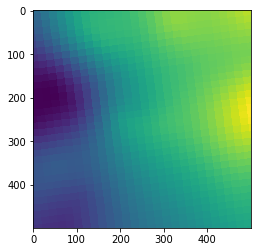

In [12]:
# now load one raster file of this stamp say bouger_gravity anomaly
tif = os.path.join(trainpath,trainids[0],'geophysics/gravity/isostatic_residual_gravity_anomaly.tif')

with rasterio.open(tif, 'r') as src:
    meta = src.meta
    data = src.read(1)

plt.imshow(data);   

In [15]:
# create a dictionary to extract geophysics file features

# open test raster file path
target_path = '/Users/pedrojunqueira/Desktop/train/75867950'

file_structure = dict()

for root, dirs, files in os.walk(target_path):
    for name in files:
        #print(os.path.join(root, name))
        ext = name.split('.')[-1]
        filename = name.split('.')[0]
        filepath = os.path.join(root, name)
        if ext == 'tif':
            first = '/'.join(filepath.split('/')[:5])
            second = '/'.join(filepath.split('/')[6:])
            file_structure[filename] = (first,second)
            file_structure[filename] = (first,second)

In [17]:
for k, v in file_structure.items():
    print(k,v)

thermal_infrared_silica_index ('/Users/pedrojunqueira/Desktop/train', 'remote_sensing/aster/thermal_infrared_silica_index.tif')
ferric_oxide_content ('/Users/pedrojunqueira/Desktop/train', 'remote_sensing/aster/ferric_oxide_content.tif')
kaolin_group_index ('/Users/pedrojunqueira/Desktop/train', 'remote_sensing/aster/kaolin_group_index.tif')
opaque_index ('/Users/pedrojunqueira/Desktop/train', 'remote_sensing/aster/opaque_index.tif')
aloh_group_composition ('/Users/pedrojunqueira/Desktop/train', 'remote_sensing/aster/aloh_group_composition.tif')
ferrous_iron_content ('/Users/pedrojunqueira/Desktop/train', 'remote_sensing/aster/ferrous_iron_content.tif')
mgoh_group_content ('/Users/pedrojunqueira/Desktop/train', 'remote_sensing/aster/mgoh_group_content.tif')
aloh_groun_content ('/Users/pedrojunqueira/Desktop/train', 'remote_sensing/aster/aloh_groun_content.tif')
thermal_infrared_gypsum_index ('/Users/pedrojunqueira/Desktop/train', 'remote_sensing/aster/thermal_infrared_gypsum_index.tif'

In [42]:
# save tiles data (average value) in a csv
start = datetime.now()

target_tif = file_structure['isostatic_residual_gravity_anomaly']

height = 500
width = 500
tilesheight = 50
tileswidth = 50

for key, value in file_structure.items():
    tile_mean = list()
    tile_id = list()
    target_tif = value
    print(f'processing... {key}')
    for n, train_i in enumerate(trainids):
        first, third = target_tif
        tif = os.path.join(first,train_i,third)
        rows = range(int(height/tilesheight))
        cols = range(int(width/tileswidth))
        count= 0
        for i in rows:
            for j in cols:
                with rasterio.open(tif, 'r') as src:
                    w = src.read(1, window=Window(i*tileswidth, j*tilesheight, 50, 50))
                    w_mean = w.mean()
                    tile_id.append(f'{train_i}_{count+1}')
                    tile_mean.append(w_mean)
                    count+=1
        if n%100 == 0:
            print(f'{n}/{len(trainids)} processed...')            

    print(f'{n+1}/{len(trainids)} processed...')
    df = pd.DataFrame({'tile_id':tile_id,'mean_':tile_mean})
    #csv_name = third.split('/')[-1].split('.')[0]                   
    df.to_csv(f'./tile_features/{key}.csv',index=False)                   


finish = datetime.now()
duration = finish - start
if duration.seconds > 60:
    print(f'this cell ran in {duration.seconds/60} minutes and {duration.seconds%60} seconds')
else:
    print(f'this cell ran in {duration.seconds} seconds')

processing... thermal_infrared_silica_index
0/1863 processed...
100/1863 processed...
200/1863 processed...
300/1863 processed...
400/1863 processed...
500/1863 processed...
600/1863 processed...
700/1863 processed...
800/1863 processed...
900/1863 processed...
1000/1863 processed...
1100/1863 processed...
1200/1863 processed...
1300/1863 processed...
1400/1863 processed...
1500/1863 processed...
1600/1863 processed...
1700/1863 processed...
1800/1863 processed...
1863/1863 processed...
processing... ferric_oxide_content
0/1863 processed...
100/1863 processed...
200/1863 processed...
300/1863 processed...
400/1863 processed...
500/1863 processed...
600/1863 processed...
700/1863 processed...
800/1863 processed...
900/1863 processed...
1000/1863 processed...
1100/1863 processed...
1200/1863 processed...
1300/1863 processed...
1400/1863 processed...
1500/1863 processed...
1600/1863 processed...
1700/1863 processed...
1800/1863 processed...
1863/1863 processed...
processing... kaolin_grou

1800/1863 processed...
1863/1863 processed...
processing... filtered_thorium_ppm
0/1863 processed...
100/1863 processed...
200/1863 processed...
300/1863 processed...
400/1863 processed...
500/1863 processed...
600/1863 processed...
700/1863 processed...
800/1863 processed...
900/1863 processed...
1000/1863 processed...
1100/1863 processed...
1200/1863 processed...
1300/1863 processed...
1400/1863 processed...
1500/1863 processed...
1600/1863 processed...
1700/1863 processed...
1800/1863 processed...
1863/1863 processed...
processing... filtered_terrestrial_dose
0/1863 processed...
100/1863 processed...
200/1863 processed...
300/1863 processed...
400/1863 processed...
500/1863 processed...
600/1863 processed...
700/1863 processed...
800/1863 processed...
900/1863 processed...
1000/1863 processed...
1100/1863 processed...
1200/1863 processed...
1300/1863 processed...
1400/1863 processed...
1500/1863 processed...
1600/1863 processed...
1700/1863 processed...
1800/1863 processed...
1863/1

In [43]:

len(tile_mean)
len(tile_id)

186300

In [18]:
# save tiles data in a list
start = datetime.now()

target_tif = file_structure['isostatic_residual_gravity_anomaly']

height = 500
width = 500
tilesheight = 50
tileswidth = 50

tiles_map = dict()
for n, train_i in enumerate(trainids):
    first, third = target_tif
    tif = os.path.join(first,train_i,third)
    rows = range(int(height/tilesheight))
    cols = range(int(width/tileswidth))
    count= 0
    for i in rows:
        for j in cols:
            with rasterio.open(tif, 'r') as src:
                w = src.read(1, window=Window(i*tileswidth, j*tilesheight, 50, 50))
                col_off = i*tileswidth
                row_off = j*tilesheight
                tiles_map[f'{train_i}_{count+1}'] = ( w , (col_off,row_off) )
                count+=1
    if n%100 == 0:
        print(f'{n}/{len(trainids)} processed...')            

print(f'{n+1}/{len(trainids)} processed...')     


finish = datetime.now()
duration = finish - start
print(f'this cell ran in {duration.seconds/60} minutes')

0/1863 processed...
100/1863 processed...
200/1863 processed...
300/1863 processed...
400/1863 processed...
500/1863 processed...
600/1863 processed...
700/1863 processed...
800/1863 processed...
900/1863 processed...
1000/1863 processed...
1100/1863 processed...
1200/1863 processed...
1300/1863 processed...
1400/1863 processed...
1500/1863 processed...
1600/1863 processed...
1700/1863 processed...
1800/1863 processed...
1863/1863 processed...
this cell ran in 57.18333333333333 minutes


In [19]:

print(len(tiles_map))

print(type(tiles_map))

186300
<class 'dict'>


# 5 - Create a dataset

In [20]:
# tuple (['StampID_Box#'], [Tile Data], [Strat_Label], [Commod_Labe1]) 


box_id = []
data = []
strat_label = []
comm_label = []

for key, value in stamp_map.items():
    i, strat, comm, _ = value
    box_id.append(key)
    tile_data = tiles_map.get(key)
    d, (_, _ ) = tile_data
    data.append(d)
    strat_label.append(strat)
    comm_label.append(comm)

dataset = (np.array(box_id), np.array(data)
           ,np.array(strat_label), np.array(comm_label))

In [21]:
stamp_box_id, features, labels, _ = dataset

print(f'data shape is: {features.shape}')


data shape is: (186300, 50, 50)


In [22]:
len(stamp_map)


186300

# Saving dataset in a HDF5 database - ALL DATA

In [23]:
# instatiate db object, open and have write permission
db = h5py.File('all_stamps_classes.hdf5', 'w')

In [24]:
# create dataset object
# define name/key, shape/dimention of the object and datatype 
data = db.create_dataset(name='features',shape=features.shape,dtype='float' )

# to add string to the database need to create a special data type str
dt = h5py.special_dtype(vlen=str)

# same process to create the dataset for string data
stamp_id = db.create_dataset('stamp_id', (len(stamp_box_id),), dtype=dt)
label = db.create_dataset('label', (len(labels),), dtype=dt)

# stamp_id = db.create_dataset(name='stamp_id',(3121,),dtype=dt )
# label = db.create_dataset(name='label',(3121,),dtype=dt )


In [25]:
# load data in the database

data[:,:,:] =  features
stamp_id[:] = stamp_box_id
label[:] = labels


In [26]:
# close database
db.close()

In [4]:
# test if reading data from database
db = h5py.File('all_stamps_classes.hdf5', 'r')

In [5]:
db.keys()

<KeysViewHDF5 ['features', 'label', 'stamp_id']>

In [6]:
# check if data saved by loading it
db['features'][-1]
db['label'][-1]
db['stamp_id'][-1]

'44310191_100'

In [7]:
# close DB
db.close()

# Smalle dataset excluding "none" deposits

In [ ]:
# tuple (['StampID_Box#'], [Tile Data], [Strat_Label], [Commod_Labe1]) 
# create a dataset subset with only samples without 'none' deposits


box_id = []
data = []
strat_label = []
comm_label = []

for key, value in stamp_map.items():
    i, strat, comm, _ = value
    if strat !='none':
        box_id.append(key)
        tile_data = tiles_map.get(key)
        d, (_, _ ) = tile_data
        data.append(d)
        strat_label.append(strat)
        comm_label.append(comm)

dataset_minerals = (np.array(box_id), np.array(data)
           ,np.array(strat_label), np.array(comm_label))

In [ ]:
stamp_box_id, features, labels, _ = dataset_minerals

In [ ]:
# inspecting arrays shapes

print(f'stamp_box_id shape is: {stamp_box_id.shape} dtype is {stamp_box_id.dtype}')

print(f'features shape is: {features.shape}  dtype is {features.dtype}')

print(f'labels is: {labels.shape} dtype is {labels.dtype}')

# Saving dataset in a HDF5 database

In [ ]:
# instatiate db object, open and have write permission
db = h5py.File('deposits_classes.hdf5', 'w')

In [ ]:
# create dataset object
# define name/key, shape/dimention of the object and datatype 
data = db.create_dataset(name='features',shape=features.shape,dtype='float' )

# to add string to the database need to create a special data type str
dt = h5py.special_dtype(vlen=str)

# same process to create the dataset for string data
stamp_id = db.create_dataset('stamp_id', (3121,), dtype=dt)
label = db.create_dataset('label', (3121,), dtype=dt)

# stamp_id = db.create_dataset(name='stamp_id',(3121,),dtype=dt )
# label = db.create_dataset(name='label',(3121,),dtype=dt )


In [ ]:
# load data in the database

data[:,:,:] =  features
stamp_id[:] = stamp_box_id
label[:] = labels


In [ ]:
# close database
db.close()

In [ ]:
# test if reading data from database
db = h5py.File('deposits_classes.hdf5', 'r')

In [ ]:
db.keys()

In [ ]:
# check if data saved by loading it
db['features'][-1]
db['label'][-1]
db['stamp_id'][-1]

In [ ]:
# close DB
db.close()

# Plot Boxplot of commodity distribution of mean gravity

In [ ]:
set(strat_label)

In [ ]:
set(comm_label)

In [ ]:
# save data in a dataframe
small_box_data = {'id':box_id, 'strat':strat_label, 'comm':comm_label}
small_box = pd.DataFrame(small_box_data)
small_box

In [ ]:
# sumarize counts grouped by commodity and stratification label
small_box.groupby(['strat','comm'])['id'].count()

In [ ]:

small_box['strat'].value_counts(normalize=True)

98% of the stamps have no deposits

In [ ]:
small_box['strat'].value_counts()

In [ ]:
data[0].mean()

In [ ]:
# create a mean data columns
small_box['mean'] = [i.mean() for i in data]

In [ ]:
small_box

In [ ]:
# plot the distribution of average per commodity
# exclude some extreme outliers only 2 datapoints in the none data
plotdata = small_box[small_box['mean']<970]
fig, ax = plt.subplots( figsize=(15,5))
sns.boxplot(x='strat',y='mean',data=plotdata, ax=ax );

In [ ]:
small_box['mean'].std()

In [ ]:
small_box['mean'].mean()

In [ ]:
small_box['mean'].max()

In [ ]:
small_box['mean'].min()

In [ ]:
# plot the chart without none class

plotdata = small_box[small_box['strat']!='none']
fig, ax = plt.subplots( figsize=(15,5))
sns.boxplot(x='strat',y='mean',data=plotdata, ax=ax );

In [ ]:
# plot the chart without none class but for each commodity type

plotdata = small_box[small_box['comm']!='none']
fig, ax = plt.subplots( figsize=(15,5))
sns.boxplot(x='comm',y='mean',data=plotdata, ax=ax );

In [ ]:
small_box['comm'].value_counts()

In [ ]:

count=0
for i in range(10000*1000):
    count+=1
    

In [ ]:
duration.seconds

# Pre Process Test Dataset

In [2]:
# create a dictionary to extract geophysics file features

# open test raster file path
target_path = '/Users/pedrojunqueira/Desktop/test/00651042'

file_structure = dict()

for root, dirs, files in os.walk(target_path):
    for name in files:
        #print(os.path.join(root, name))
        ext = name.split('.')[-1]
        filename = name.split('.')[0]
        filepath = os.path.join(root, name)
        if ext == 'tif':
            first = '/'.join(filepath.split('/')[:5])
            second = '/'.join(filepath.split('/')[6:])
            file_structure[filename] = (first,second)
            file_structure[filename] = (first,second)

In [5]:
# set path of the test dataset
testpath = '/Users/pedrojunqueira/Desktop/test'

# create a list with the id of the stamps
testids = os.listdir(testpath)
len(testids)


622

In [7]:
# save tiles data (average value) in a csv
start = datetime.now()

height = 500
width = 500
tilesheight = 50
tileswidth = 50

for key, value in file_structure.items():
    tile_mean = list()
    tile_id = list()
    target_tif = value
    print(f'processing... {key}')
    for n, test_i in enumerate(testids):
        first, third = target_tif
        tif = os.path.join(first,test_i,third)
        rows = range(int(height/tilesheight))
        cols = range(int(width/tileswidth))
        count= 0
        for i in rows:
            for j in cols:
                with rasterio.open(tif, 'r') as src:
                    w = src.read(1, window=Window(i*tileswidth, j*tilesheight, 50, 50))
                    w_mean = w.mean()
                    tile_id.append(f'{test_i}_{count+1}')
                    tile_mean.append(w_mean)
                    count+=1
        if n%100 == 0:
            print(f'{n}/{len(testids)} processed...')            

    print(f'{n+1}/{len(testids)} processed...')
    df = pd.DataFrame({'tile_id':tile_id,'mean_':tile_mean})
    df.to_csv(f'./tile_features/{key}_test.csv',index=False)                   


finish = datetime.now()
duration = finish - start
if duration.seconds > 60:
    print(f'this cell ran in {duration.seconds/60} minutes and {duration.seconds%60} seconds')
else:
    print(f'this cell ran in {duration.seconds} seconds')

processing... thermal_infrared_silica_index
0/622 processed...
100/622 processed...
200/622 processed...
300/622 processed...
400/622 processed...
500/622 processed...
600/622 processed...
622/622 processed...
processing... ferric_oxide_content
0/622 processed...
100/622 processed...
200/622 processed...
300/622 processed...
400/622 processed...
500/622 processed...
600/622 processed...
622/622 processed...
processing... kaolin_group_index
0/622 processed...
100/622 processed...
200/622 processed...
300/622 processed...
400/622 processed...
500/622 processed...
600/622 processed...
622/622 processed...
processing... opaque_index
0/622 processed...
100/622 processed...
200/622 processed...
300/622 processed...
400/622 processed...
500/622 processed...
600/622 processed...
622/622 processed...
processing... aloh_group_composition
0/622 processed...
100/622 processed...
200/622 processed...
300/622 processed...
400/622 processed...
500/622 processed...
600/622 processed...
622/622 process